In [1]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn

#Shared/Utility scripts
import sys
sys.path.insert(0, '../..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval, dataloader, mlp_dataprocessing, mlp_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HOME = os.path.expanduser('~')


modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
print(f"{modelname} development script")

Device: cuda
Device: cuda
Device: cuda
MLP development script


In [2]:
modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

cfsday_AFday = 1.983

#input columns
input_columns =[
                'Lat', 
                'Long', 
                'Drainage_area_mi2', 
                'Mean_Basin_Elev_ft',       
                'Perc_Forest', 
                'Perc_Develop', 
                'Perc_Imperv', 
                'Perc_Herbace',       
                'Perc_Slop_30', 
                'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', 
                'NWM_flow', 
                'DOY', 
                'tempe(F)', 
                'precip(mm)'
                ]

target = 'flow_cfs'

test_years = [2019, 2020]                 



In [3]:
#Get streamstats data 
datapath = f"{HOME}/NWM_ML/Data/input"
trainingfile = "final_input.parquet"

df, StreamStats = dataloader.get_ML_Data(datapath, trainingfile)
df.head()

df needs no processing


,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301,39.239582,0.0
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302,45.068712,0.0
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303,50.945891,0.0
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304,45.480097,0.0
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305,46.656777,0.0


### Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [4]:
#get non headwater stations
headwater_stations = ['10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                        '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                        '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                        '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                        '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                        '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                          '10172952'
                          ] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#get stations with correct swe and storage features
#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''

stations = df['station_id'][(df['swe']>0) & (df['storage']>0)].unique()

#Train model with these stations
df = df[df['station_id'].isin(stations)]

#convert dates to datetime format
df.datetime = pd.to_datetime(df.datetime)

# #reset index to clean up df
df.reset_index( inplace =  True, drop = True)

df.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-28,1162.60410,-0.891007,-0.453991,34.071895,1.142857,1183.0,301,41.423048,0.0
1,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-29,1152.39590,-0.891007,-0.453991,34.673203,1.128571,1181.0,302,52.055238,0.0
2,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-30,1036.51040,-0.891007,-0.453991,35.346405,1.071429,1181.0,303,51.981724,0.0
3,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-31,680.29170,-0.891007,-0.453991,36.039216,1.078571,1179.0,304,43.891912,0.0
4,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-11-01,557.59375,-0.998630,0.052336,36.699346,1.100000,1175.0,305,45.246638,0.0


In [5]:
#fit a scaler,save, and scale the training data
x_train_scaled, y_scaled_train = mlp_dataprocessing.mlp_scaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

x_test_scaled, y_test_temp, x_test_temp, station_index_list = mlp_dataprocessing.mlp_testscaler(
                                                      df,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      )

# Convert to tensor for PyTorch
x_train_scaled_t = torch.Tensor(x_train_scaled)
y_train_scaled_t = torch.Tensor(y_scaled_train)
#Make sure the tensors on are the respective device (cpu/gpu)
x_train_scaled_t = x_train_scaled_t.to(device)
y_train_scaled_t = y_train_scaled_t.to(device)



(26089, 1)
(26089, 18)
(3834, 18)


### Set up Testing year
* Select year(s) not used in training
* Convert to numpy array
* Load scaler and scale data

## Train the model

* randomize training data..
* add training loss https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

In [6]:
#Train the model
# Hyperparameters
epochs = 10
batch_size = 100
learning_rate = 0.0001  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/
decay = 0.0005
validation_split = 0.25 #where to put this??
layers = x_train_scaled_t.shape[1], 128,128,64,64,32,16
params =  learning_rate, decay, epochs, batch_size
loss_func = nn.MSELoss()

mlp_model.mlp_train(x_train_scaled_t,y_train_scaled_t, layers, params, loss_func, model_path, modelname)


Epoch 1/10, Loss: 0.004391107693273517
Epoch 2/10, Loss: 0.0038842826834576513
Epoch 3/10, Loss: 0.002910955010095283
Epoch 4/10, Loss: 0.0023618091500615807
Epoch 5/10, Loss: 0.0020017351117631835
Epoch 6/10, Loss: 0.0017187232868629953
Epoch 7/10, Loss: 0.0014785706593366912
Epoch 8/10, Loss: 0.0013057132546167279
Epoch 9/10, Loss: 0.0011619666953244642
Epoch 10/10, Loss: 0.0010682112290109132
finish
Run Time: 6.151813268661499 seconds 


## Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES

In [7]:
#Train the model
# Hyperparameters
epochs = 10
batch_size = 100
learning_rate = 0.0001  #look up learning rate scheduler https://www.geeksforgeeks.org/understanding-pytorch-learning-rate-scheduling/
decay = 0.0005
layers = x_test_scaled.shape[1], 128,128,64,64,32,16

Preds_Dict = mlp_model.mlp_predict(test_years, 
                      layers, 
                      model_path, 
                      modelname, 
                      stations, 
                      x_test_temp,
                      x_test_scaled, 
                      y_test_temp,
                      StreamStats,
                      station_index_list)


# Evaluate model performance for held out testing data

USGS site: 10126000


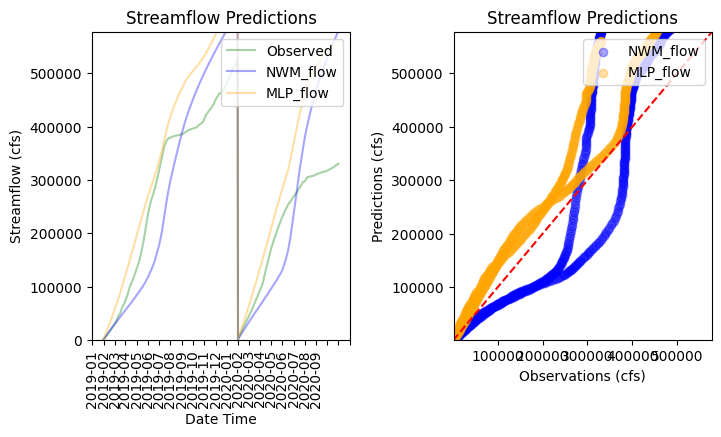

USGS site: 10134500


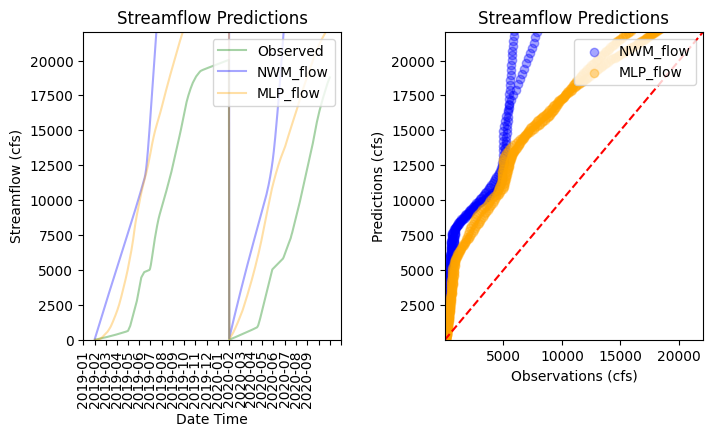

USGS site: 10136500


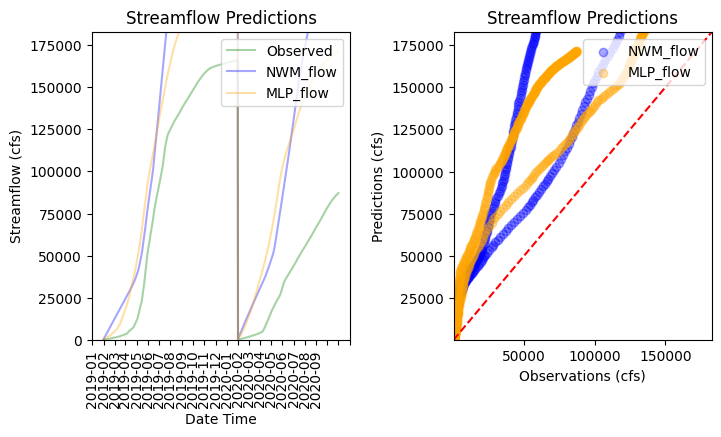

USGS site: 10140700


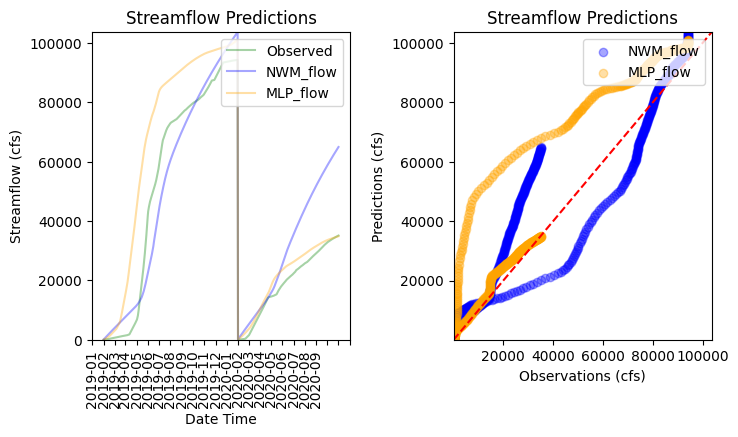

USGS site: 10141000


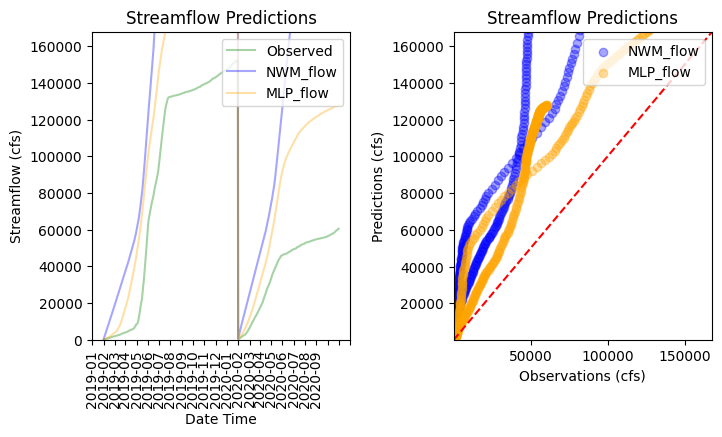

USGS site: 10155200


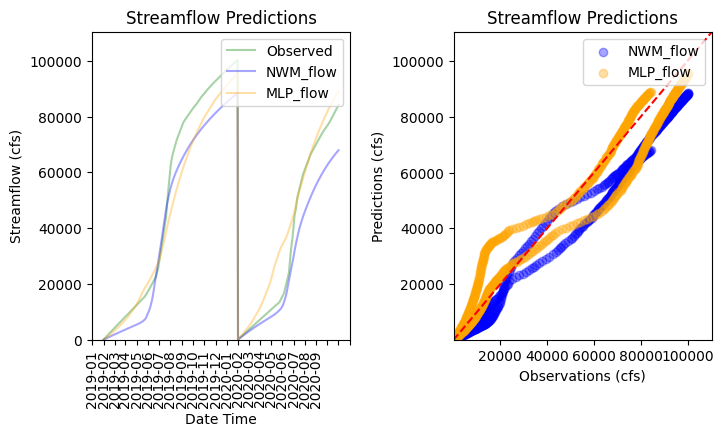

In [8]:
#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, prediction_columns, modelname, supply = True)

In [9]:
Eval_DF

,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias,min_storage,max_storage,min_swe,max_swe,min_obs_flow,max_obs_flow,NWM_flow_min,NWM_flow_fmax,MLP_flow_min,MLP_flow_fmax
station_id,,,,,,,,,,,,,,,,,,
10155200,0.79,0.89,9328.121589,8088.410491,24.25,24.50,16.80,1.54,60.559554,99.461783,0.0,16.900000,120.958336,100321.588740,65.0,88432.0,95.993210,95738.523438
10140700,0.88,0.73,12146.402310,14022.818115,121.94,126.11,-10.28,-24.94,38.329994,100.776464,0.0,37.300000,18.252083,94286.544726,133.0,103674.0,58.109909,100950.820312
10126000,0.59,0.54,97633.129922,108474.212655,29.79,39.82,-5.45,-33.39,33.856209,97.627451,0.0,18.121429,846.000000,525395.786482,977.0,615453.0,1782.671265,672253.500000
10134500,-1.44,0.34,19693.914087,5808.003288,442.84,166.29,-191.96,-61.95,54.783838,101.432323,0.0,27.300000,5.775104,20050.382894,86.0,57265.0,0.000000,28976.396484
10141000,-2.05,0.29,192444.182955,48248.762770,329.41,102.81,-225.70,-62.44,42.555835,101.306864,0.0,26.740000,66.993750,152560.973978,610.0,516493.0,100.655167,212307.453125
10136500,-0.45,0.26,100328.689225,55781.429092,279.64,202.91,-115.63,-69.26,42.941763,101.853396,0.0,25.062500,43.652775,166318.328877,413.0,353585.0,136.810104,232343.968750
